In [10]:
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpStatus, value

# Load the data
parameters_c = pd.read_excel('parameters_c.xlsx')
parameters_x = pd.read_excel('parameters_X.xlsx')

# Extract parameters
p = parameters_c['p'][0]
AEM = parameters_c['AEM'][0]
ATD = parameters_c['ATD'][0]
e_f = parameters_c['e_f'][0]
e_s = parameters_c['e_s'][0]

# Constants for constraints
M = 100  # Large constant for the binary linkage
epsilon = 1e-6  # Small positive number for the strict inequality

# Helper function to create variables and constraints
def create_model(d_m=1):
    model = LpProblem("EV_Charging_Plug_Installation", LpMinimize)
    x_f = LpVariable.dicts("x_fast", parameters_x['i'], lowBound=0, cat='Integer')
    x_s = LpVariable.dicts("x_slow", parameters_x['i'], lowBound=0, cat='Integer')
    y = LpVariable.dicts("lot_with_station", parameters_x['i'], cat=LpBinary)

    # Demand Satisfaction
    for i in parameters_x['i']:
        neighbors = eval(parameters_x.loc[i, 'N'])
        model += (lpSum([(e_f * (parameters_x.loc[j, 'x_fast_existing'] + x_f[j]) +
                          e_s * (parameters_x.loc[j, 'x_slow_existing'] + x_s[j])) *
                         parameters_x.loc[j, 'Hours'] for j in neighbors]) >=
                  lpSum([parameters_x.loc[j, 'Capacity'] * p * AEM * ATD for j in neighbors]*d_m)), f"Demand_{i}"

    # Energy Distribution Limit
    for i in parameters_x['i']:
        model += (e_f * (parameters_x.loc[i, 'x_fast_existing'] + x_f[i]) +
                  e_s * (parameters_x.loc[i, 'x_slow_existing'] + x_s[i])) * parameters_x.loc[i, 'Hours'] <= parameters_x.loc[i, 'Max_energy'], f"MaxEnergy_{i}"

    # Linkage Constraints
    for i in parameters_x['i']:
        # Ensure that if y_i = 0, then x_f[i] + x_s[i] = 0
        model += x_f[i] + x_s[i] + parameters_x.loc[i, 'x_fast_existing'] +parameters_x.loc[i, 'x_slow_existing'] <= M * y[i], f"Linkage_Upper_{i}"
        # Ensure that if y_i = 1, then x_f[i] + x_s[i] > 0
        #model += x_f[i] + x_s[i] + parameters_x.loc[i, 'x_fast_existing'] +parameters_x.loc[i, 'x_slow_existing'] >= epsilon * y[i], f"Linkage_Lower_{i}"

    # Non-negativity
    for i in parameters_x['i']:
        model += x_f[i] >= 0
        model += x_s[i] >= 0
        model += y[i] >= 0

    return model, x_f, x_s, y

# Step 1: Optimize to minimize the total number of plugs
model1, x_f1, x_s1, y1 = create_model()
model1 += lpSum([x_f1[i] + x_s1[i] for i in parameters_x['i']]), "Total_Plugs"
model1.solve()
min_total_plugs = value(model1.objective)

# Step 2: Optimize to minimize the number of lots with stations while keeping the total number of plugs <= min_total_plugs
model2, x_f2, x_s2, y2 = create_model()
model2 += lpSum([y2[i] for i in parameters_x['i']]), "Number_of_Lots_with_Stations"
model2 += lpSum([x_f2[i] + x_s2[i] for i in parameters_x['i']]) <= min_total_plugs, "Min_Total_Plugs"

# Solve the combined model
model2.solve()

# Collect results
results = {
    "Parking Lot": [],
    "Fast Plugs": [],
    "Slow Plugs": [],
    "Station Installed": []
}

for i in parameters_x['i']:
    results["Parking Lot"].append(i)
    results["Fast Plugs"].append(x_f2[i].varValue)
    results["Slow Plugs"].append(x_s2[i].varValue)
    results["Station Installed"].append(y2[i].varValue)

results_df = pd.DataFrame(results)
print("Status:", LpStatus[model2.status])
print("Objective Value:", value(model2.objective))
print(results_df)


Status: Optimal
Objective Value: 16.0
    Parking Lot  Fast Plugs  Slow Plugs  Station Installed
0             0         0.0         0.0                0.0
1             1         1.0         0.0                1.0
2             2         0.0         0.0                0.0
3             3         1.0         0.0                1.0
4             4         1.0         0.0                1.0
5             5         1.0         0.0                1.0
6             6         1.0         0.0                1.0
7             7         1.0         0.0                1.0
8             8         0.0         0.0                0.0
9             9         1.0         0.0                1.0
10           10         0.0         0.0                1.0
11           11         0.0         0.0                0.0
12           12         0.0         0.0                1.0
13           13         0.0         0.0                1.0
14           14         0.0         0.0                1.0
15           15   

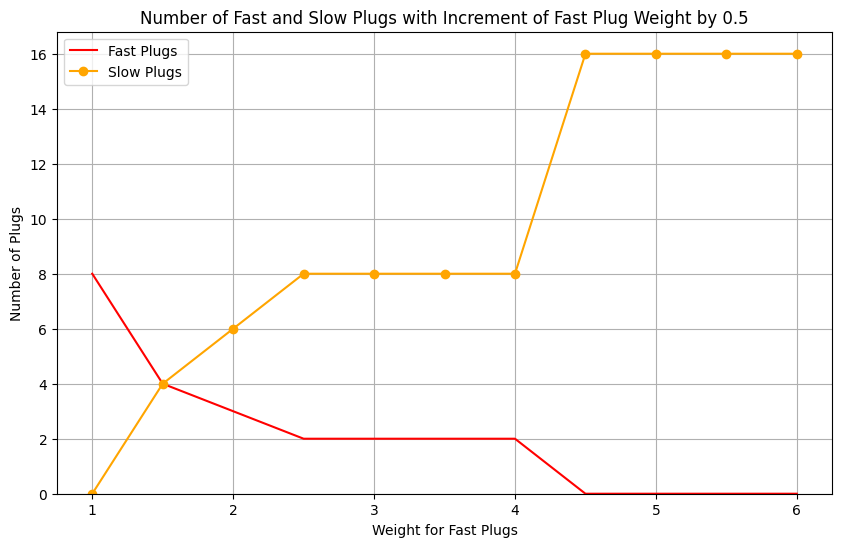

In [12]:
import matplotlib.pyplot as plt

# Updated data after state reset
weights = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
fast_plugs = [8.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0]
slow_plugs = [0.0, 4.0, 6.0, 8.0, 8.0, 8.0, 8.0, 16.0, 16.0, 16.0, 16.0]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(weights, fast_plugs, label='Fast Plugs', color='red')
plt.plot(weights, slow_plugs, marker='o', label='Slow Plugs', color='orange')

# Setting up labels and title
plt.xlabel('Weight for Fast Plugs')
plt.ylabel('Number of Plugs')
plt.title('Number of Fast and Slow Plugs with Increment of Fast Plug Weight by 0.5')

# Setting the y-axis to start from 0
plt.ylim(bottom=0)

# Adding grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [9]:
import numpy as np

w_f = 2
for d_m in np.arange(1,11,0.1):
    # Step 1: Minimize total number of plugs
    model1, x_f1, x_s1, y1 = create_model(d_m)
    model1 += lpSum([w_f * x_f1[i] + x_s1[i] for i in parameters_x['i']]), "Total_Plugs"
    model1.solve()
    min_total_plugs = value(model1.objective)

    # Step 2: Minimize number of lots with stations, constrained by the total plugs from Step 1
    model2, x_f2, x_s2, y2 = create_model(d_m)
    model2 += lpSum([y2[i] for i in parameters_x['i']]), "Number_of_Lots_with_Stations"
    model2 += lpSum([w_f * x_f2[i] +  x_s2[i] for i in parameters_x['i']]) <= min_total_plugs, "Min_Total_Plugs"
    model2.solve()

    # Output results
    print(f"Demand multiplier: {d_m}")
    if model2.status == 1:
        # print(f"Total Plugs Constrained to: {min_total_plugs}")
        print(f"Lots with Stations: {sum(y2[i].varValue for i in parameters_x['i'])}")
        print(f"Fast Plugs = {sum(x_f2[i].varValue for i in parameters_x['i'])}, Slow Plugs = {sum(x_s2[i].varValue for i in parameters_x['i'])}")
    else:
        print("No optimal solution found.")
    print("-" * 40)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
import folium
import pandas as pd

data = {
    "Parking Lot": range(21),  # 21 parking lots
    "latitude": [41.885756, 41.8873452, 41.8851588, 41.8849865, 41.8676015,
                 41.8810344, 41.8778467, 41.8836196, 41.885803, 41.8794475,
                 41.884568, 41.883932, 41.885378, 41.88531, 41.88531,
                 41.8859377, 41.8853949, 41.88532, 41.883209, 41.8805546, 41.878095],
    "longitude": [-87.6277696, -87.6195255, -87.6188454, -87.6165376, -87.6204227,
                  -87.6222783, -87.6240934, -87.6242233, -87.625797, -87.6258586,
                  -87.627268, -87.629438, -87.629408, -87.62213, -87.62213,
                  -87.6310907, -87.6335693, -87.635474, -87.633859, -87.6356046, -87.628461],
    "Fast Plugs": [0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    "Slow Plugs": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "Station Installed": [0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
}

# Convert data to DataFrame
locations_df = pd.DataFrame(data)

# Create a map centered around the average coordinates
m = folium.Map(location=[locations_df['latitude'].mean(), locations_df['longitude'].mean()], zoom_start=13)

# Add markers for each parking lot with popup details
for idx, row in locations_df.iterrows():
    station_status = "Installed" if row['Station Installed'] == 1 else "Not Installed"
    popup_text = f"Parking Lot: {row['Parking Lot']}<br>Fast Plugs: {row['Fast Plugs']}<br>Slow Plugs: {row['Slow Plugs']}<br>Station: {station_status}"
    color = 'blue' if row['Fast Plugs'] == 1 else ('green' if row['Station Installed'] == 1 else 'red')
    folium.Circle(
        location=(row['latitude'], row['longitude']),
        radius=100,
        color=color,
        fill=True,
        fill_color=color,
        popup=popup_text
    ).add_to(m)

m
